# ATIVIDADE 2 -- PROCESSAMENTO DIGITAL DE IMAGENS



### INTEGRANTES
|**Participantes**|**RA**|
|-|-|
|Bruno Matos de Souza|769754|
|Gustavo M. Barreto|790832|
|Lucas Maciel Balieiro|800534|


In [38]:
#impotacao das bibliotecas

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from  sklearn.cluster import KMeans
import ants ,os
from antspynet.utilities import brain_extraction

ATLAS_IMG_DIR     = "Atlas"
CLINICS_IMG_DIR   = "imagens-clinicas"
EXTRACTED_BRAIN_DIR = 'skull-strip-images'

# Facilitar o acesso aos arquivos
AtlasPaths = {
    "REF": f"{ATLAS_IMG_DIR}/mni_ref.nii.gz",
    "MASK": f"{ATLAS_IMG_DIR}/mni_ref.nii.gz",
    "CSF": f"{ATLAS_IMG_DIR}/mni_csf.nii.gz",
    "GM" : f"{ATLAS_IMG_DIR}/mni_gm.nii.gz",
    "WM" : f"{ATLAS_IMG_DIR}/mni_wm.nii.gz"
}

# lista dos arquivos
clinics_files, skull_stripped_files = [],[]
for f in os.listdir(CLINICS_IMG_DIR):
    clinics_files.append(os.path.join(CLINICS_IMG_DIR, f))
    skull_stripped_files.append(os.path.join(EXTRACTED_BRAIN_DIR, f))

## EXTRAÇÃO DA REGIÃO DE INTERESSE
O ANTsPy se baseia nos algoritmos do ANTs (Advanced Normalization Tools), que utilizam técnicas como registro de imagens, segmentação e transformações não-lineares para processamento de imagens médicas, especialmente em neuroimagem, como a extração automática do cérebro de imagens de ressonância magnética. Eles utilizam algoritmos clássicos de processamento de imagens, como registro de imagens, transformações não-lineares e modelos de atlas para segmentação.

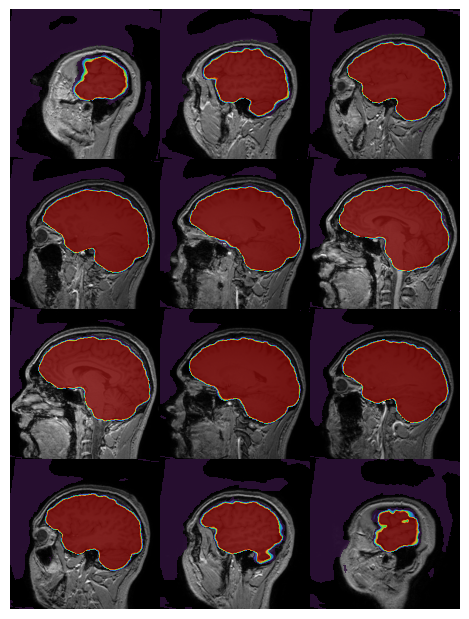

In [ ]:
'''
Nesta etapa, removemos estruturas não observadas. 
Com o ajuste de registro feito pelo pacote ANTs, armazenamos as 
imagens clinicas com as devidas extrações. Isso permite um melhor controle
sobre a etapa seguinte - mensurar o volume de cada estrutura.
'''

for (idx, img) in enumerate(clinics_files):
    t1 = ants.image_read((img))                                   # image read
    brain_image_ants = brain_extraction(t1, modality="t1")        # brain extract - bin mask
    tmp = t1 * brain_image_ants
    tmp.to_filename(skull_stripped_files[idx])                    # image save

# plote the last as example
ants.plot(t1, overlay=brain_image_ants, overlay_alpha=0.8)


NameError: name 'reorient_and_resample' is not defined

In [2]:

def reorient_and_resample(moving_image, fixed_image):
    """
    Reorienta e reamostra a imagem moving_image para ter a mesma orientação e tamanho da fixed_image.
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(sitk.Transform())  # Usa uma transformação identidade para reorientação
    return resampler.Execute(moving_image)

def register_with_elastix(fixed_image, moving_image):
    elastix = sitk.ElastixImageFilter()
    elastix.SetFixedImage(fixed_image)
    elastix.SetMovingImage(moving_image)
    parameter_map = sitk.GetDefaultParameterMap('affine') 
    parameter_map["Transform"] = ["BSplineTransform"]  # Usando B-splines
    parameter_map["Regularization"] = ["0.1"]  # Controlando a força da regularização
    parameter_map["MaximumStepSize"] = ["0.01"]
    parameter_map["MinimumStepSize"] = ["0.001"]
    parameter_map["NumberOfResolutions"] = ["4"]
    parameter_map["MaximumNumberOfIterations"] = ["200"]


    elastix.SetParameterMap(parameter_map) 

    # Executa o registro
    elastix.Execute()
    
    # Retorna a imagem registrada e os parâmetros da transformação
    return elastix.GetResultImage(), elastix.GetTransformParameterMap()

def apply_transform_with_elastix(image, fixed_image, transform_param):
    """
    Aplica a transformação obtida pelo Elastix a uma imagem.
    """
    transformix = sitk.TransformixImageFilter()
    transformix.SetTransformParameterMap(transform_param)
    transformix.SetMovingImage(image)
    transformix.Execute()
    
    return transformix.GetResultImage()


In [8]:
mri_image = sitk.ReadImage(ClinicalImgPaths[1])

# Carregar os atlas e as máscaras
atlas_image = sitk.ReadImage(AtlasPaths["REF"])  # Atlas de referência
gm_atlas    = sitk.ReadImage(AtlasPaths["GM"])  # Matéria Cinzenta
wm_atlas    = sitk.ReadImage(AtlasPaths["WM"])  # Matéria Branca
csf_atlas   = sitk.ReadImage(AtlasPaths["CSF"])  # Líquor

atlas_image = reorient_and_resample(atlas_image, mri_image)
gm_atlas    = reorient_and_resample(gm_atlas, mri_image)
wm_atlas    = reorient_and_resample(wm_atlas, mri_image)
csf_atlas   = reorient_and_resample(csf_atlas, mri_image)

# Registrar o atlas na MRI usando Elastix (transformação afim)
registered_atlas, transform_param = register_with_elastix(mri_image, atlas_image)

# Aplicar a transformação obtida às máscaras GM, WM e CSF
gm_aligned = apply_transform_with_elastix(gm_atlas, mri_image, transform_param)
wm_aligned = apply_transform_with_elastix(wm_atlas, mri_image, transform_param)
csf_aligned = apply_transform_with_elastix(csf_atlas, mri_image, transform_param)

# Salvar os resultados
sitk.WriteImage(registered_atlas, "atlas_alinhado.nii.gz")
sitk.WriteImage(gm_aligned, "gm_alinhado.nii.gz")
sitk.WriteImage(wm_aligned, "wm_alinhado.nii.gz")
sitk.WriteImage(csf_aligned, "csf_alinhado.nii.gz")

ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used
  The default value "3" is used instead.
  The default value "false" is used instead.

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
Initialization of all components (before registration) took: 0 ms.
Preparation of the image pyramids took: 924 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used i

## SEGMENTAÇÃO DOS PRINCIPAIS TECIDOS



### MÉTODO K-MEANS
Para este método, usaremos funções já implementadas do pacote `sckit-learn`.

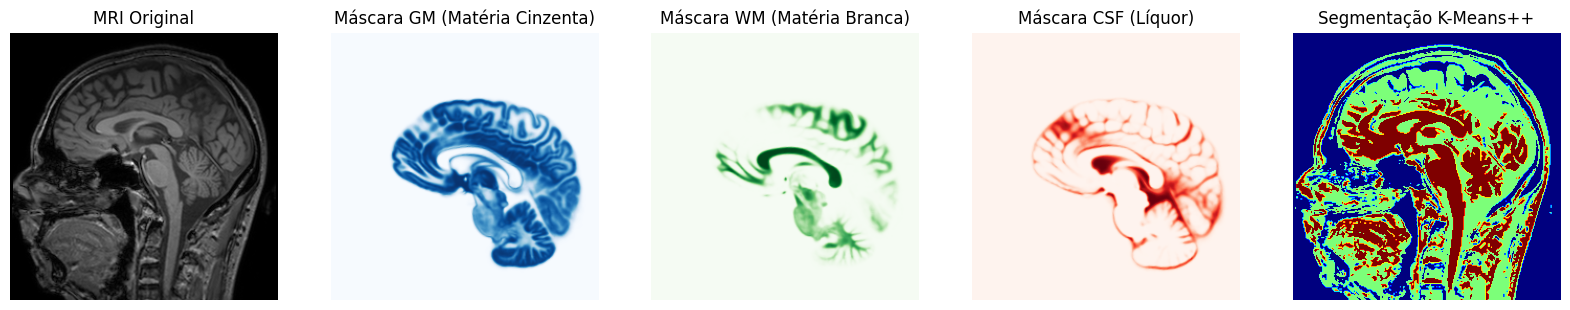

In [5]:

def reorient_image(image, reference):
    return sitk.Resample(image, reference, sitk.Transform(), sitk.sitkLinear, 0.0, image.GetPixelID())

def align_mask(mask, reference_mri):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_mri)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)  # Mantém os valores discretos da máscara
    resampler.SetTransform(sitk.Transform())             # Usa a identidade para alinhamento
    aligned_mask = resampler.Execute(mask)
    return aligned_mask

def normalize_image(image_array: np.ndarray):
    mx = np.max(image_array)
    mn = np.min(image_array)
    
    return (image_array - mn) / (mx - mn)


amostragem = 0.01

def kmeans_method(image_path, atlas_paths, sample_rate=0.01, n_clusters=3):
    # Carregar a imagem de ressonância magnética
    sitk_image = sitk.ReadImage(image_path)
    image_array = sitk.GetArrayFromImage(sitk_image)
    
    # Normalizar a imagem
    image_array = normalize_image(image_array)

    # Carregar e reorientar as máscaras do atlas
    masks = {key: reorient_image(sitk.ReadImage(path), sitk_image) for key, path in atlas_paths.items()}
    
    # Converter máscaras para arrays e normalizar
    masks = {key: normalize_image(sitk.GetArrayFromImage(mask)) for key, mask in masks.items()}

    # Redimensionar imagem para vetor (1D) para clustering
    depth, height, width = image_array.shape
    flat_image = image_array.reshape(-1, 1)

    # Aplicar amostragem
    num_samples = int(len(flat_image) * sample_rate)
    sample_indices = np.random.choice(len(flat_image), num_samples, replace=False)
    sample_data = flat_image[sample_indices]

    # Aplicar K-Means++
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(sample_data)

    # Obter rótulos para todos os pixels
    segmented_labels = kmeans.predict(flat_image)
    segmented_image = segmented_labels.reshape(depth, height, width)

    return sitk_image, image_array, masks, segmented_image

# Definir caminhos dos arquivos
image_path =ClinicalImgPaths[2]

# Rodar K-Means++ com 1% de amostragem
sitk_image, image_array, masks, segmented_image = kmeans_method(image_path, AtlasPaths, sample_rate=0.01)

# Visualizar os resultados
slice_index = image_array.shape[0] // 2  # Fatia central

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Imagem Original
axes[0].imshow(image_array[slice_index], origin='lower',cmap="gray")
axes[0].set_title("MRI Original")
axes[0].axis("off")

# Máscara GM
axes[1].imshow(masks["GM"][slice_index], origin='lower',cmap="Blues")
axes[1].set_title("Máscara GM (Matéria Cinzenta)")
axes[1].axis("off")

# Máscara WM
axes[2].imshow(masks["WM"][slice_index], origin='lower',cmap="Greens")
axes[2].set_title("Máscara WM (Matéria Branca)")
axes[2].axis("off")

# Máscara CSF
axes[3].imshow(masks["CSF"][slice_index], origin='lower',cmap="Reds")
axes[3].set_title("Máscara CSF (Líquor)")
axes[3].axis("off")

# Segmentação K-Means++
axes[4].imshow(segmented_image[slice_index], origin='lower',cmap="jet")
axes[4].set_title("Segmentação K-Means++")
axes[4].axis("off")

plt.show()

### MÉTODO GAUSSIAN MIXTURE MODEL



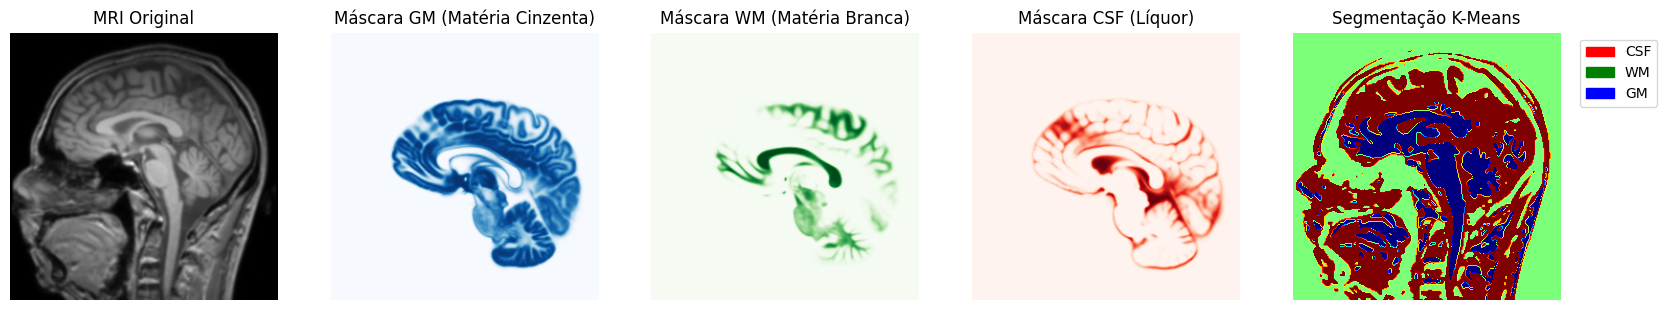

In [6]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

# Função para reorientar a imagem
def reorient_image(image, reference):
    return sitk.Resample(image, reference, sitk.Transform(), sitk.sitkLinear, 0.0, image.GetPixelID())

# Função para alinhar a máscara
def align_mask(mask, reference_mri):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_mri)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)  # Mantém os valores discretos da máscara
    resampler.SetTransform(sitk.Transform())             # Usa a identidade para alinhamento
    aligned_mask = resampler.Execute(mask)
    return aligned_mask

# Função para normalizar a imagem
def normalize_image(image_array: np.ndarray):
    mx = np.max(image_array)
    mn = np.min(image_array)
    return (image_array - mn) / (mx - mn)

# Função para aplicar o filtro Gaussiano
def apply_gaussian_filter(image_array, sigma=1):
    return gaussian_filter(image_array, sigma=sigma)

# Função principal do K-Means
def kmeans_method(image_path, atlas_paths, sample_rate=0.01, n_clusters=3):
    # Carregar a imagem de ressonância magnética
    sitk_image = sitk.ReadImage(image_path)
    image_array = sitk.GetArrayFromImage(sitk_image)
    
    # Pré-processamento: Normalizar e aplicar filtro Gaussiano
    image_array = normalize_image(image_array)
    image_array = apply_gaussian_filter(image_array, sigma=1)

    # Carregar e reorientar as máscaras do atlas
    masks = {key: reorient_image(sitk.ReadImage(path), sitk_image) for key, path in atlas_paths.items()}
    
    # Converter máscaras para arrays e normalizar
    masks = {key: normalize_image(sitk.GetArrayFromImage(mask)) for key, mask in masks.items()}

    # Inicializar os centróides do K-Means com base no atlas
    initial_centroids = np.array([
        np.mean(image_array[masks["WM"] > 0.5]),  # Média para WM
        np.mean(image_array[masks["GM"] > 0.5]),  # Média para GM
        np.mean(image_array[masks["CSF"] > 0.5])  # Média para CSF
    ]).reshape(-1, 1)

    # Redimensionar imagem para vetor (1D) para clustering
    depth, height, width = image_array.shape
    flat_image = image_array.reshape(-1, 1)

    # Aplicar amostragem estratificada
    sample_indices = []
    for key in masks:
        mask_indices = np.where(masks[key].flatten() > 0.5)[0]
        sample_indices.extend(np.random.choice(mask_indices, int(len(mask_indices) * sample_rate), replace=False))
    sample_data = flat_image[sample_indices]

    # Aplicar K-Means com inicialização personalizada
    kmeans = KMeans(n_clusters=n_clusters, init=initial_centroids, n_init=1, random_state=42)
    kmeans.fit(sample_data)

    # Obter rótulos para todos os pixels
    segmented_labels = kmeans.predict(flat_image)
    segmented_image = segmented_labels.reshape(depth, height, width)

    return sitk_image, image_array, masks, segmented_image

# Definir caminhos dos arquivos
image_path = ClinicalImgPaths[2]

# Rodar K-Means com 1% de amostragem
sitk_image, image_array, masks, segmented_image = kmeans_method(image_path, AtlasPaths, sample_rate=0.01)

# Visualizar os resultados
slice_index = image_array.shape[0] // 2  # Fatia central

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Imagem Original
axes[0].imshow(image_array[slice_index], origin='lower', cmap="gray")
axes[0].set_title("MRI Original")
axes[0].axis("off")

# Máscara GM
axes[1].imshow(masks["GM"][slice_index], origin='lower', cmap="Blues")
axes[1].set_title("Máscara GM (Matéria Cinzenta)")
axes[1].axis("off")

# Máscara WM
axes[2].imshow(masks["WM"][slice_index], origin='lower', cmap="Greens")
axes[2].set_title("Máscara WM (Matéria Branca)")
axes[2].axis("off")

# Máscara CSF
axes[3].imshow(masks["CSF"][slice_index], origin='lower', cmap="Reds")
axes[3].set_title("Máscara CSF (Líquor)")
axes[3].axis("off")

# Segmentação K-Means com legenda
segmented_slice = segmented_image[slice_index]
segmented_plot = axes[4].imshow(segmented_slice, origin='lower', cmap="jet")
axes[4].set_title("Segmentação K-Means")
axes[4].axis("off")

# Adicionar legenda
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["red", "green", "blue"])
legend_labels = {0: "CSF", 1: "WM", 2: "GM"}
handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(3)]
plt.legend(handles, [legend_labels[i] for i in range(3)], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Função para redimensionar o atlas para corresponder à imagem clínica
def resample_atlas_to_image(atlas, reference_image):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(sitk.Transform())
    resampler.SetOutputPixelType(reference_image.GetPixelID())
    resampled_atlas = resampler.Execute(atlas)
    return resampled_atlas

# Função para realizar a registração e alinhar o atlas com a imagem clínica
def register_atlas_to_image(atlas, reference_image):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    initial_transform = sitk.CenteredTransformInitializer(reference_image, atlas, sitk.Euler3DTransform())
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    final_transform = registration_method.Execute(atlas, reference_image)
    registered_atlas = sitk.Resample(atlas, reference_image, final_transform, sitk.sitkLinear, 0.0, atlas.GetPixelID())
    return registered_atlas, final_transform

def register_atlas_to_image_bspline(atlas, reference_image, mesh_size=[3, 3, 3], iterations=20):
    """
    Alinha o atlas à imagem clínica usando BSplineTransform (registração não rígida).
    
    Parâmetros:
        atlas (SimpleITK.Image): Atlas a ser alinhado.
        reference_image (SimpleITK.Image): Imagem clínica de referência.
        mesh_size (list): Densidade da malha de controle (ex: [5,5,5]).
        iterations (int): Número de iterações do otimizador.
    
    Retorna:
        SimpleITK.Image: Atlas alinhado.
        sitk.BSplineTransform: Transformação aplicada.
    """
    # Configurar o método de registração
    registration_method = sitk.ImageRegistrationMethod()
    

    # Multi-resolução (3 níveis)
    registration_method.SetShrinkFactorsPerLevel([4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel([2, 1, 0])
    
    # Transformação BSpline com malha grossa
    initial_transform = sitk.BSplineTransformInitializer(
        reference_image,
        transformDomainMeshSize=mesh_size,
    )
    # Métrica de similaridade (Mutual Information)
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    
    # Otimizador (Gradient Descent)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=iterations,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # Configurar a transformação BSpline
    initial_transform = sitk.BSplineTransformInitializer(
        reference_image,
        transformDomainMeshSize=mesh_size,
    )
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    # Executar a registração
    final_transform = registration_method.Execute(atlas, reference_image)
    
    # Aplicar a transformação ao atlas
    registered_atlas = sitk.Resample(
        atlas,
        reference_image,
        final_transform,
        sitk.sitkLinear,
        0.0,
        atlas.GetPixelID(),
    )
    
    return registered_atlas, final_transform

# Função para aplicar a mesma transformação a outros atlas
def apply_transform_to_atlas(atlas, reference_image, transform):
    registered_atlas = sitk.Resample(atlas, reference_image, transform, sitk.sitkLinear, 0.0, atlas.GetPixelID())
    return registered_atlas

def register_atlas_to_image_affine(atlas, reference_image):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=20)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # Usar AffineTransform (permite translação, rotação, escala e cisalhamento)
    initial_transform = sitk.CenteredTransformInitializer(reference_image, atlas, sitk.AffineTransform(3))
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    # Executar a registração
    final_transform = registration_method.Execute(atlas, reference_image)
    
    # Aplicar a transformação no atlas
    registered_atlas = sitk.Resample(atlas, reference_image, final_transform, sitk.sitkLinear, 0.0, atlas.GetPixelID())
    return registered_atlas, final_transform


# Visualizar os resultados
def plot_slices(image, title, cmap="gray"):
    slice_index = image.shape[0] // 2  # Fatia central
    plt.imshow(image[slice_index], cmap=cmap, origin='lower')
    plt.title(title)
    plt.axis("off")

def convert_to_float32(image):
    return sitk.Cast(image, sitk.sitkFloat32)

def normalize_image(image):
    # Normalizar a imagem para o intervalo [0, 1]
    normalizer = sitk.NormalizeImageFilter()
    return normalizer.Execute(image)


def visualize_checkerboard(image1, image2, checker_pattern=[10, 10, 10], slice_index=None):
    """
    Cria uma imagem de checkerboard a partir de duas imagens e visualiza uma fatia.

    Parâmetros:
        image1_path (str): Caminho para a primeira imagem (ex: imagem clínica).
        image2_path (str): Caminho para a segunda imagem (ex: atlas).
        checker_pattern (list): Tamanho dos blocos em cada dimensão (ex: [10, 10, 10]).
        slice_index (int): Índice da fatia a ser visualizada. Se None, usa a fatia central.
    """
    # Carregar as imagens
    #image1 = sitk.ReadImage(image1_path)
    #image2 = sitk.ReadImage(image2_path)

    # Certificar-se de que as imagens têm as mesmas dimensões
    image2_resampled = sitk.Resample(image2, image1, sitk.Transform(), sitk.sitkLinear, 0.0, image2.GetPixelID())

    image2_resampled = normalize_image(image2_resampled)
    image1 = normalize_image(image1)


    # Criar a imagem de checkerboard
    checkerboard_image = sitk.CheckerBoard(image1, image2_resampled, checkerPattern=checker_pattern)

    # Converter a imagem de checkerboard para um array NumPy
    checkerboard_array = sitk.GetArrayFromImage(checkerboard_image)

    # Selecionar a fatia para visualização
    if slice_index is None:
        slice_index = checkerboard_array.shape[0] // 2  # Fatia central

    # Visualizar a fatia
    plt.imshow(checkerboard_array[slice_index], cmap="gray", origin='lower')
    plt.title(f"Checkerboard: Fatia {slice_index}")
    plt.axis("off")
    plt.show()




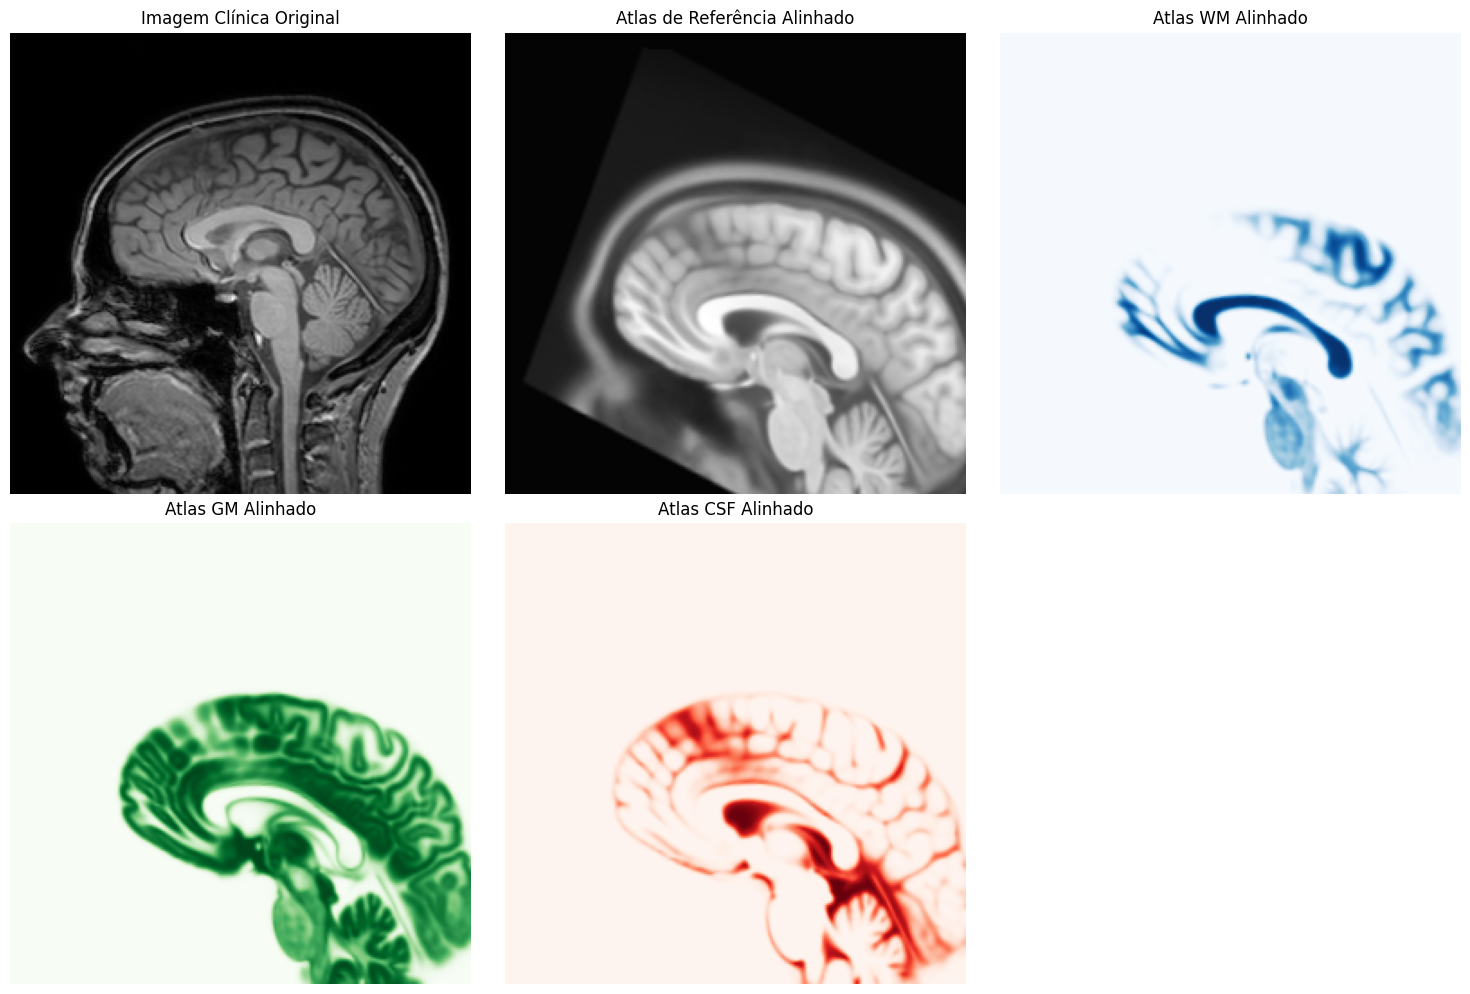

In [11]:

# Carregar a imagem clínica
clinical_image = sitk.ReadImage(ClinicalImgPaths[3])

# Carregar os atlas
atlas_reference = sitk.ReadImage(AtlasPaths['REF'])
atlas_wm        = sitk.ReadImage(AtlasPaths['WM'])
atlas_gm        = sitk.ReadImage(AtlasPaths['GM'])
atlas_csf       = sitk.ReadImage(AtlasPaths['CSF'])


# Converter as imagens para float32
clinical_image_float32 = convert_to_float32(clinical_image)
atlas_reference_float32 = convert_to_float32(atlas_reference)
atlas_wm_float32 = convert_to_float32(atlas_wm)
atlas_gm_float32 = convert_to_float32(atlas_gm)
atlas_csf_float32 = convert_to_float32(atlas_csf)

# Redimensionar os atlas para corresponder à imagem clínica
atlas_reference_resampled = resample_atlas_to_image(atlas_reference_float32, clinical_image_float32)

# Alinhar o atlas de referência com a imagem clínica usando AffineTransform
atlas_wm_resampled = resample_atlas_to_image(atlas_wm_float32, clinical_image_float32)
atlas_gm_resampled = resample_atlas_to_image(atlas_gm_float32, clinical_image_float32)
atlas_csf_resampled = resample_atlas_to_image(atlas_csf_float32, clinical_image_float32)

# Alinhar o atlas de referência com a imagem clínica
#registered_reference, final_transform = register_atlas_to_image(atlas_reference_resampled, clinical_image_float32)
registered_reference, final_transform = register_atlas_to_image_affine(atlas_reference_resampled, clinical_image_float32)

# Aplicar a mesma transformação aos outros atlas
registered_wm = apply_transform_to_atlas(atlas_wm_resampled, clinical_image_float32, final_transform)
registered_gm = apply_transform_to_atlas(atlas_gm_resampled, clinical_image_float32, final_transform)
registered_csf = apply_transform_to_atlas(atlas_csf_resampled, clinical_image_float32, final_transform)
# Plotar as imagens

clinical_array = sitk.GetArrayFromImage(clinical_image_float32)
registered_reference_array = sitk.GetArrayFromImage(registered_reference)
registered_wm_array = sitk.GetArrayFromImage(registered_wm)
registered_gm_array = sitk.GetArrayFromImage(registered_gm)
registered_csf_array = sitk.GetArrayFromImage(registered_csf)

# Plotar as imagens
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plot_slices(clinical_array, "Imagem Clínica Original")

plt.subplot(2, 3, 2)
plot_slices(registered_reference_array, "Atlas de Referência Alinhado")

plt.subplot(2, 3, 3)
plot_slices(registered_wm_array, "Atlas WM Alinhado", cmap="Blues")

plt.subplot(2, 3, 4)
plot_slices(registered_gm_array, "Atlas GM Alinhado", cmap="Greens")

plt.subplot(2, 3, 5)
plot_slices(registered_csf_array, "Atlas CSF Alinhado", cmap="Reds")

plt.tight_layout()
plt.show()


Centroides alinhados. Transformação inicial:
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.1976298200852138, 9.192054049527615, -6.591660852581983)


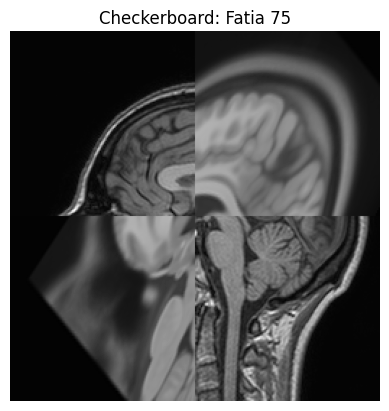

In [20]:
import SimpleITK as sitk

def align_images_with_composite_transform(
    fixed_image_path: str,
    moving_image_path: str,
    use_composite: bool = False,
    initial_mesh_size: list = [5, 5, 5],
    num_iterations: int = 100,
    learning_rate: float = 1.0,
    verbose: bool = False
):
    """
    Alinha duas imagens usando alinhamento de centroides + transformação afim, 
    com opção de compor transformações adicionais.

    Parâmetros:
        fixed_image_path (str): Caminho da imagem de referência (fixa).
        moving_image_path (str): Caminho da imagem a ser alinhada (móvel).
        use_composite (bool): Se True, retorna uma transformação composta.
        initial_mesh_size (list): Tamanho da malha para inicialização (apenas para visualização).
        num_iterations (int): Número de iterações para a registração afim.
        learning_rate (float): Taxa de aprendizado do otimizador.
        verbose (bool): Exibe informações de debug.

    Retorna:
        tuple: (imagem_alinhada, transformação) 
               (se use_composite=False, retorna a transformação afim final).
    """
    # 1. Carregar imagens
    fixed_image = sitk.ReadImage(fixed_image_path)
    moving_image = sitk.ReadImage(moving_image_path)

    # Converter para float32
    fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
    moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)

    # 2. Alinhamento inicial de centroides
    initial_transform = sitk.AffineTransform(3)
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        initial_transform,
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )

    if verbose:
        print("Centroides alinhados. Transformação inicial:")
        print(initial_transform.GetParameters())

    # 3. Configurar registração afim
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=learning_rate,
        numberOfIterations=num_iterations
    )
    registration_method.SetInitialTransform(initial_transform)
    
    # 4. Executar registração
    final_transform = registration_method.Execute(fixed_image, moving_image)

    # 5. Aplicar transformação
    aligned_image = sitk.Resample(
        moving_image,
        fixed_image,
        final_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID()
    )

    # 6. Compor transformações se solicitado
    if use_composite:
        composite_transform = sitk.CompositeTransform(3)
        composite_transform.AddTransform(initial_transform)
        composite_transform.AddTransform(final_transform)
        return aligned_image, composite_transform
    else:
        return aligned_image, final_transform
    


aligned_image, affine_transform = align_images_with_composite_transform(
    fixed_image_path=ClinicalImgPaths[0],
    moving_image_path=AtlasPaths["REF"],
    num_iterations=50,
    learning_rate=1.5,
    verbose=True
)



visualize_checkerboard(sitk.ReadImage(ClinicalImgPaths[0]), 
                       aligned_image,
                       checker_pattern=3*[2],  # Tamanho dos blocos
                       slice_index=None  # Visualiza a fatia centra
)


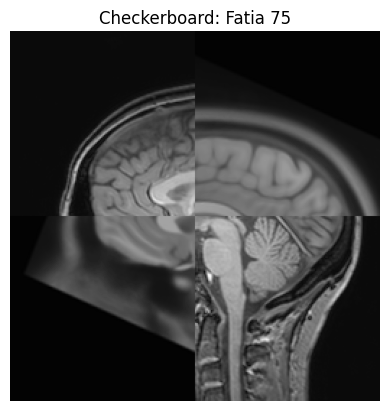

In [17]:
# Exemplo de uso

def resample_to_match(moving_image, fixed_image):
    """Redimensiona a imagem móvel para corresponder à imagem fixa."""
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetOutputPixelType(fixed_image.GetPixelID())
    return resampler.Execute(moving_image)





visualize_checkerboard(
    image1=(clinical_image_float32),
    image2=(atlas_reference_float32),
    checker_pattern=3*[2],  # Tamanho dos blocos
    slice_index=None  # Visualiza a fatia central
)




### AVALIAÇÃO -- VARIAÇÃO DA TX. AMOSTRAL



In [ ]:
# import SimpleITK as sitk

# def register_images(fixed_image_path, moving_image_path):
#     # Carregar imagens
#     fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
#     moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
    
#     # Inicialização do método de registro
#     registration_method = sitk.ImageRegistrationMethod()
#     registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
#     registration_method.SetInterpolator(sitk.sitkLinear)
    
#     # Definição da transformação BSpline
#     transformDomainMeshSize = [10] * moving_image.GetDimension()
#     initial_transform = sitk.BSplineTransformInitializer(fixed_image, transformDomainMeshSize)
#     registration_method.SetInitialTransformAsBSpline(initial_transform, inPlace=True)
    
#     # Otimização
#     registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=300)
    
#     # Executar o registro
#     final_transform = registration_method.Execute(fixed_image, moving_image)
    
#     return final_transform

# def apply_transform(fixed_image_path, moving_image_path, transform, output_path):
#     fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
#     moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
    
#     resampler = sitk.ResampleImageFilter()
#     resampler.SetReferenceImage(fixed_image)
#     resampler.SetInterpolator(sitk.sitkLinear)
#     resampler.SetTransform(transform)
    
#     transformed_image = resampler.Execute(moving_image)
#     sitk.WriteImage(transformed_image, output_path)

# # Caminhos dos arquivos
# fixed_image_path = ClinicalImgPaths[1]
# moving_image_path = AtlasPaths["REF"]

# gm_path   =  AtlasPaths["GM"]
# wm_path   =  AtlasPaths["WM"]
# csf_path  =  AtlasPaths["CSF"]

# # Registrar atlas ao exame clínico
# final_transform = register_images(fixed_image_path, moving_image_path)

# # Aplicar transformação nas segmentações GM, WM e CSF
# apply_transform(fixed_image_path, gm_path, final_transform,  "gm_alinhado.nii.gz")
# apply_transform(fixed_image_path, wm_path, final_transform,  "wm_alinhado.nii.gz")
# apply_transform(fixed_image_path, csf_path, final_transform, "csf_alinhado.nii.gz")


# # Visualizar os resultados
# slice_index = image_array.shape[0] // 2  # Fatia central

# fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# # Imagem Original
# axes[0].imshow(image_array[slice_index], origin='lower',cmap="gray")
# axes[0].set_title("MRI Original")
# axes[0].axis("off")

# # Máscara GM
# axes[1].imshow(masks["GM"][slice_index], origin='lower',cmap="Blues")
# axes[1].set_title("Máscara GM (Matéria Cinzenta)")
# axes[1].axis("off")

# # Máscara WM
# axes[2].imshow(masks["WM"][slice_index], origin='lower',cmap="Greens")
# axes[2].set_title("Máscara WM (Matéria Branca)")
# axes[2].axis("off")

# # Máscara CSF
# axes[3].imshow(masks["CSF"][slice_index], origin='lower',cmap="Reds")
# axes[3].set_title("Máscara CSF (Líquor)")
# axes[3].axis("off")

# # Segmentação K-Means++
# axes[4].imshow(segmented_image[slice_index], origin='lower',cmap="jet")
# axes[4].set_title("Segmentação K-Means++")
# axes[4].axis("off")


In [ ]:
# Inicializar método de registro
# Carregar imagens
clinical_image   = sitk.ReadImage(ClinicalImgPaths[0])
img_atlas_ref = sitk.ReadImage(AtlasPaths["REF"])
img_atlas_wm  = sitk.ReadImage(AtlasPaths["WM"])
img_atlas_gm  = sitk.ReadImage(AtlasPaths["GM"])
img_atlas_csf = sitk.ReadImage(AtlasPaths["CSF"])

clinical_image_float32   = convert_to_float32(clinical_image)
atlas_reference_float32  = convert_to_float32(atlas_reference)
atlas_wm_float32         = convert_to_float32(atlas_wm)
atlas_gm_float32         = convert_to_float32(atlas_gm)
atlas_csf_float32        = convert_to_float32(atlas_csf)
registro_afim            = sitk.ImageRegistrationMethod()


# Métrica de similaridade (Mutual Information)
registro_afim.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registro_afim.SetMetricSamplingStrategy(registro_afim.RANDOM)
registro_afim.SetMetricSamplingPercentage(0.1)

# Otimizador (Gradient Descent)
registro_afim.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)

# Configurações multirresolução
registro_afim.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registro_afim.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registro_afim.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Transformação afim inicial
transformacao_afim = sitk.CenteredTransformInitializer(
    img_atlas_ref, 
    clinical_image, 
    sitk.AffineTransform(3)
)

# Executar registro
transformacao_afim = registro_afim.Execute(
    sitk.Cast(img_atlas_ref, sitk.sitkFloat32),
    sitk.Cast(clinical_image, sitk.sitkFloat32),
    transformacao_afim
)

TypeError: Execute() takes 3 positional arguments but 4 were given

In [20]:
import SimpleITK as sitk
import SimpleITK as sitk

def load_image(image_path):
    """Carrega uma imagem NIfTI"""
    return sitk.ReadImage(image_path)

def save_image(image, output_path):
    """Salva uma imagem NIfTI"""
    sitk.WriteImage(image, output_path)

def create_brain_mask(image, threshold=50):
    """
    Cria uma máscara binária do cérebro usando threshold.
    """
    mask = sitk.BinaryThreshold(image, lowerThreshold=threshold, upperThreshold=255)
    mask = sitk.BinaryMorphologicalClosing(mask, (3,3,3))  # Remove ruído
    return mask

def register_images(fixed_image, moving_image, parameter_file, mask=None):
    """Executa o registro usando Elastix"""
    elastix = sitk.ElastixImageFilter()
    elastix.SetFixedImage(fixed_image)
    elastix.SetMovingImage(moving_image)
    elastix.SetParameterMap(sitk.ReadParameterFile(parameter_file))
    
    if mask:
        elastix.SetFixedMask(mask)  # Aplica a máscara para focar no cérebro
    
    elastix.Execute()
    return elastix.GetResultImage(), elastix.GetTransformParameterMap()

def segment_brain_region(image, seed_threshold=(1,6000), refine_threshold=(0,600)):
    """
    Segmenta o cérebro removendo partes externas (exemplo: crânio e pescoço).
    """
    # Criar máscara inicial
    thresh = sitk.BinaryThreshold(image, lowerThreshold=seed_threshold[0], upperThreshold=seed_threshold[1])
    thresh = sitk.BinaryThreshold(image, lowerThreshold=refine_threshold[0], upperThreshold=refine_threshold[1])

    # Aplicar operações morfológicas para refinar
    mask = sitk.BinaryMorphologicalClosing(thresh, (5,5,5))  
    mask = sitk.BinaryMorphologicalOpening(mask, (5,5,5))  

    return mask

def apply_mask(image, mask):
    """Aplica uma máscara a uma imagem para remover regiões externas"""
    return sitk.Mask(image, mask)

# ====== ETAPA 1: Carregar Imagens ======
fixed_image  = load_image(ClinicalImgPaths[0])  
moving_image = load_image(AtlasPaths['REF'])  

# ====== ETAPA 2: Criar Máscara do Cérebro ======
brain_mask = create_brain_mask(fixed_image)
save_image(brain_mask, "mascara_cerebro.nii.gz")

# ====== ETAPA 3: Transformação pelo Centróide ======
registered_centroid, transform_centroid = register_images(
    fixed_image, moving_image, "parameters_centroid.txt"
)
save_image(registered_centroid, "saida_centroid.nii.gz")

# ====== ETAPA 4: Transformação Afim ======
registered_affine, transform_affine = register_images(
    fixed_image, registered_centroid, "parameters_affine.txt", brain_mask
)
save_image(registered_affine, "saida_afim.nii.gz")

# ====== ETAPA 5: Transformação Deformável ======
registered_deformable, _ = register_images(
    fixed_image, registered_affine, "parameters_deformable.txt", brain_mask
)
save_image(registered_deformable, "saida_deformada.nii.gz")

# ====== ETAPA 6: Segmentação do Cérebro ======
brain_segmented = segment_brain_region(registered_deformable)
save_image(brain_segmented, "segmentacao_cerebro.nii.gz")

# ====== ETAPA 7: Aplicar Máscara ao MRI ======
brain_final = apply_mask(fixed_image, brain_segmented)
save_image(brain_final, "mri_cerebro_final.nii.gz")

print("Pipeline concluído! Verifique as imagens geradas.")


  The default value "MultiResolutionRegistration" is used instead.
  The default value "FixedSmoothingImagePyramid" is used instead.
  The default value "MovingSmoothingImagePyramid" is used instead.
  The default value "BSplineInterpolator" is used instead.
  The default value "FinalBSplineInterpolator" is used instead.
  The default value "DefaultResampler" is used instead.
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
Transform parameters are initial

RuntimeError: Exception thrown in SimpleITK ElastixImageFilter_Execute: /home/francesco/SimpleElastix/Code/Elastix/src/sitkElastixImageFilterImpl.cxx:259:
sitk::ERROR: 
itk::ExceptionObject (0x5bb63fc31e60)
Location: "unknown" 
File: /home/francesco/SimpleElastix/build/Elastix/Core/Main/elxElastixFilter.hxx
Line: 253
Description: itk::ERROR: ElastixFilter(0x5bb64639db80): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



In [8]:
import itk
!pip install itk-stripts


ERROR: Could not find a version that satisfies the requirement itk-stripts (from versions: none)
ERROR: No matching distribution found for itk-stripts


In [8]:
import SimpleITK as sitk
import itk
import numpy as np
import matplotlib.pyplot as plt

# Função para converter de SimpleITK para ITK
def sitk_to_itk(sitk_image):
    itk_image = itk.GetImageFromArray(sitk.GetArrayFromImage(sitk_image))
    itk_image.SetOrigin(sitk_image.GetOrigin())
    itk_image.SetSpacing(sitk_image.GetSpacing())
    itk_image.SetDirection(itk.GetMatrixFromArray(np.reshape(sitk_image.GetDirection(), [3, 3])))
    return itk_image

# Função para converter de ITK para SimpleITK
def itk_to_sitk(itk_image):
    sitk_image = sitk.GetImageFromArray(itk.GetArrayFromImage(itk_image))
    sitk_image.SetOrigin(itk_image.GetOrigin())
    sitk_image.SetSpacing(itk_image.GetSpacing())
    sitk_image.SetDirection(tuple(itk.GetArrayFromMatrix(itk_image.GetDirection()).flatten()))
    return sitk_image

# Carregar imagem no SimpleITK
image_path = ClinicalImgPaths[0]  # Substitua pelo caminho correto
sitk_image = sitk.ReadImage(image_path)

# Converter para ITK
itk_image = sitk_to_itk(sitk_image)

# Aplicar StripTsImageFilter no ITK
strip_filter = itk.StripTsImageFilter.New(itk_image)
strip_filter.SetAtlas("oasis")  # Escolha um atlas apropriado
strip_filter.Update()
brain_itk_image = strip_filter.GetOutput()

# Converter de volta para SimpleITK
brain_sitk_image = itk_to_sitk(brain_itk_image)

# Salvar a imagem processada
sitk.WriteImage(brain_sitk_image, "imagem_sem_cranio.nii.gz")

# Função para visualizar uma fatia axial da imagem
def show_image(image, title="Imagem"):
    array = sitk.GetArrayFromImage(image)
    plt.imshow(array[array.shape[0] // 2, :, :], cmap="gray")  # Fatia axial
    plt.title(title)
    plt.axis("off")
    plt.show()

# Mostrar imagens antes e depois
show_image(sitk_image, "Original")
show_image(brain_sitk_image, "Sem Crânio")


AttributeError: PyCapsule_Import "_ITKCommonPython._C_API" is not valid

#